In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import itertools
import pandas as pd

In [2]:
def clust_coef(G, nodes = None, weight = None):
    if nodes is None:
        nodes = G.nodes()
    c = nx.clustering(G,nodes,weight)
    return(c)

In [3]:
def l_graph(G):
    return nx.line_graph(G)

def lineToG(l_clusters,node_ID_df):
    clusters = []
    for cluster in l_clusters:
        clusters.append({node_ID_df.loc[node_ID_df['ids']==node,'nodes'].tolist()[0] for edge in cluster for node in edge})
    return clusters

In [5]:
def label_to_id(G):
    df = nx.to_pandas_edgelist(G)
    nodes = list(G.nodes())
    IDs = range(1,len(nodes)+1)
    nodes_ids_df = pd.DataFrame({'nodes':nodes,'ids':IDs})
    source_ids = [nodes_ids_df.loc[nodes_ids_df['nodes']==n,'ids'].tolist()[0] for n in df['source'] ]
    target_ids = [nodes_ids_df.loc[nodes_ids_df['nodes']==n,'ids'].tolist()[0] for n in df['target'] ]
    df_ids = pd.DataFrame({'source':source_ids,'target':target_ids,'weight':df['weight']})   
    G_ids = nx.from_pandas_edgelist(df_ids,source="source",target="target",edge_attr="weight")
    return G_ids,nodes_ids_df

In [6]:
def weight_lineG(G,lineG):
    for e in lineG.edges():
        w1 = G.get_edge_data(e[0][0],e[0][1])
        w2 = G.get_edge_data(e[1][0],e[1][1])
        w = (w1['weight'] + w2['weight'])/2
        lineG[e[0]][e[1]]['weight'] = w
    return lineG

In [7]:
def clustCoef_clustering(G, weight="weight"):
    if nx.is_weighted(G):
        w = weight
    else:
        w = 'None'
    cluster = []
    node_set = list(G.nodes())
    v_cc_G = clust_coef(G,node_set,w)
    sort_coef_G = sorted(v_cc_G.items(), key=lambda item: item[1], reverse=True)
    v = sort_coef_G[0][0]
    first_neigh_v = list(G.neighbors(v)) + [v]
    [node_set.remove(x) for x in first_neigh_v]
    cluster.append(first_neigh_v)
    neighbor2 = []
    [neighbor2.extend(list(G.neighbors(x))) for x in list(G.neighbors(v))]
    nodes_nextRound = set(neighbor2) - set(first_neigh_v)
    updated_coef = [sort_coef_G[i] for i,r in enumerate(sort_coef_G) if not(r[0] in neighbor2) ]
    G.remove_nodes_from(first_neigh_v)
    while (len(G.nodes())!=0):
        v_cc = clust_coef(G,nodes_nextRound,w)
        sort_coef = sorted(v_cc.items(), key=lambda item: item[1], reverse=True)
        updated_coef.extend(sort_coef)
        sort_coef = sorted(updated_coef, key=lambda tup: tup[1], reverse=True)
        v = sort_coef[0][0]
        first_neigh_v = list(G.neighbors(v)) + [v]
        [node_set.remove(x) for x in first_neigh_v]
        cluster.append(first_neigh_v)
        neighbor2 = []
        [neighbor2.extend(list(G.neighbors(x))) for x in list(G.neighbors(v))]
        nodes_nextRound = set(neighbor2) - set(first_neigh_v)
        updated_coef = [sort_coef[i] for i,
                        r in enumerate(sort_coef) if not(r[0] in neighbor2 or r[0] in first_neigh_v)]
        G.remove_nodes_from(first_neigh_v)
    return(cluster)

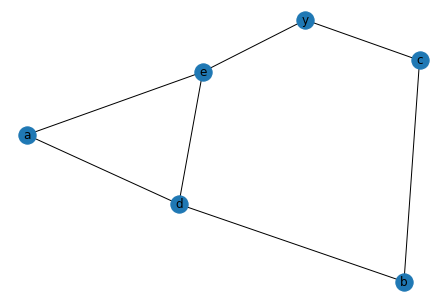

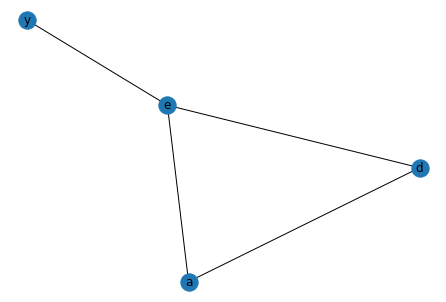

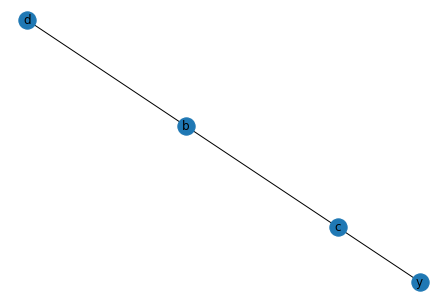

In [8]:
G = nx.Graph()
G.add_edge("a", "e", weight=1/2)
G.add_edge("a", "d", weight=1/2)
G.add_edge("e", "d", weight=1/2)
G.add_edge("b", "d", weight=1/3)
G.add_edge("b", "c", weight=1/2)
G.add_edge("d", "e", weight=2)
G.add_edge("c", "y", weight=2)
G.add_edge("e", "y", weight=3)
nx.draw(G,with_labels=True)
plt.show()

G_id,nodeID = label_to_id(G.copy()) 
l = l_graph(G_id)
if nx.is_weighted(G_id):
    l = weight_lineG(G_id,l)
l_clusters = clustCoef_clustering(l)
G_clusters = lineToG(l_clusters,nodeID)
G_clusters.sort(key=len, reverse=True)
for cmp in G_clusters:
    s = nx.induced_subgraph(G,cmp)
    if len(s)>= 2:
        nx.draw(s,with_labels = True)
        plt.show()